In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics 


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

### LOAD DATA

In [2]:
path_train="https://raw.githubusercontent.com/deepu-san/Projects/main/Click%20Through%20Rate%20Pred/train.csv"
path_test="https://raw.githubusercontent.com/deepu-san/Projects/main/Click%20Through%20Rate%20Pred/test.csv"
df = pd.read_csv(path_train)
df_test=pd.read_csv(path_test)
df_testcopy = df_test.copy()

In [ ]:
df.info()

### EDA

**Removing or modifying certain features**

1) is_timer indicates if an email contains a timer or not.

In [ ]:
df['is_timer'].value_counts()

0    1888
Name: is_timer, dtype: int64

All the available data have is_timer values to be 0 (no timer). So this features is redundant and can be removed.

In [3]:
df.drop(columns = ['is_timer'], inplace = True)

2) Its stated in the information that 'is_price' indicates if the email contains a price or not. But the actual data indicates whether there is no price (0) and different price amounts (5499, 8000, 5000 etc.).

In [ ]:
df['is_price'].value_counts()

0        1875
5499        5
8000        2
5000        2
4999        1
1399        1
1000        1
14999       1
Name: is_price, dtype: int64

Since, frequency of all the price values added together is very less, we can group them all together to 1 (referring to yes).

In [4]:
# converting all non zero values to 1
df['is_price'] = df['is_price'].apply(lambda x: 1 if x != 0 else 0)

Now is_price is a binary category with 1 (yes) and 0 (no).

3) campaign_id and sender information can be ignored as they are just identification.

In [5]:
df.drop(columns = ['campaign_id', 'sender'], inplace = True)

**Categorical features**

In [ ]:
cat_features = ['day_of_week', 'times_of_day','category','product','is_image','is_personalised','is_quote','is_emoticons',
               'is_discount','is_price','is_urgency','target_audience']

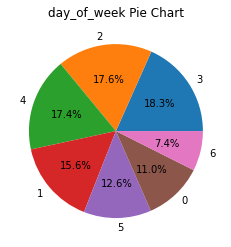

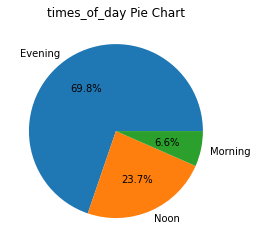

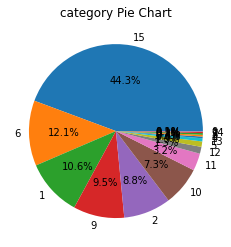

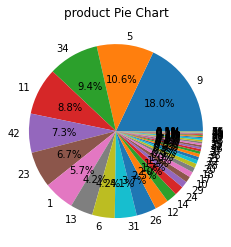

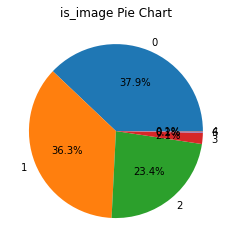

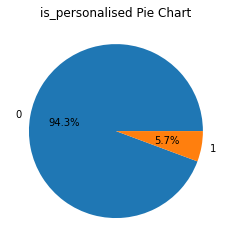

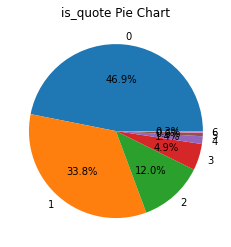

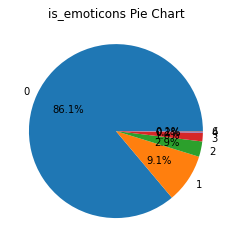

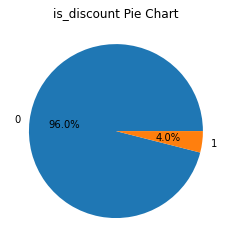

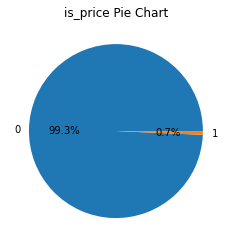

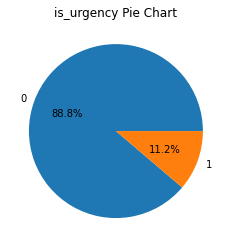

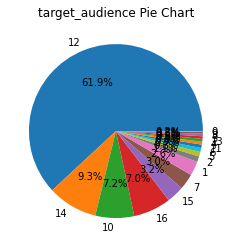

In [ ]:
# plotting pie chart
for feature in cat_features:
    labels = df[feature].value_counts().index.tolist()
    sizes = df[feature].value_counts().tolist()

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', radius=1)
    plt.title(f'{feature} Pie Chart')
    plt.show()

**Category feature**

In [6]:
# joining the less frequent is image classes together
df['is_quote'] = df['is_quote'].apply(lambda x: 'others' if x not in [0,1,2,3] else str(x))

In [ ]:
# average click rate of each category
df.groupby('is_emoticons')['click_rate'].mean().sort_values(ascending = False)

is_emoticons
0    0.045905
2    0.037820
4    0.022907
6    0.015958
1    0.011607
3    0.009313
Name: click_rate, dtype: float64

In [7]:
# joining the less frequent is image classes together
df['is_emoticons'] = df['is_emoticons'].apply(lambda x: 'others' if x not in [0,1,2] else str(x))

In [ ]:
df['is_emoticons'].value_counts()

0         1626
1          172
2           54
others      36
Name: is_emoticons, dtype: int64

**is price** (dropping is price)

In [8]:
# dropping is price because of very few 1 value and less effect on click rate
df.drop(columns = ['is_price'], inplace = True)

**target audience**

In [ ]:
num_features = []
for elem in list(df.columns):
    if elem not in cat_features:
        num_features.append(elem)
        
num_features

['subject_len',
 'body_len',
 'mean_paragraph_len',
 'is_weekend',
 'no_of_CTA',
 'mean_CTA_len',
 'click_rate']

#### Target encoding

In [10]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.4 MB/s 


In [11]:
from category_encoders.target_encoder import TargetEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install category_encoders

**Category feature**

In [12]:
# need to convert the integer values representing each category
# to string for target encoders to work
df['category'] = df['category'].apply(lambda x: str(x))
df['target_audience'] = df['target_audience'].apply(lambda x: str(x))
df['product'] = df['product'].apply(lambda x: str(x))

In [13]:
te_category = TargetEncoder()
df['category'] = te_category.fit_transform(df['category'], df['click_rate'])

te_target = TargetEncoder()
df['target_audience'] = te_target.fit_transform(df['target_audience'], df['click_rate'])

te_product = TargetEncoder()
df['product'] = te_product.fit_transform(df['product'], df['click_rate'])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


### Fitting Models

We can apply one hot encoding on the multiclass variables: product, category, times of day and target audience.

In [14]:
df1 = df.copy()

In [17]:
# one hot encoding
df1 = pd.get_dummies(df1, drop_first = True)
df1.head()

,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,...,is_urgency,target_audience,click_rate,is_quote_1,is_quote_2,is_quote_3,is_quote_others,is_emoticons_1,is_emoticons_2,is_emoticons_others
0,76,10439,39,6,1,1,0.067375,0.060373,3,29,...,0,0.091743,0.103079,0,0,0,0,0,0,0
1,54,2570,256,6,1,2,0.079360,0.079360,0,22,...,0,0.040149,0.700000,0,0,0,0,0,0,0
2,59,12801,16,6,1,1,0.079360,0.079360,3,23,...,0,0.006947,0.002769,1,0,0,0,0,0,0
3,74,11037,30,3,0,0,0.023565,0.018442,4,24,...,0,0.040149,0.010868,0,0,0,0,0,0,0
4,80,10011,27,6,1,1,0.067375,0.060373,3,31,...,0,0.091743,0.142826,1,0,0,0,0,0,0


**Scaling**

In [18]:
X = df1.drop(columns = ['click_rate'])
y = df1['click_rate']

In [38]:
X.shape

(1888, 22)

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.34001052, -0.51145873,  0.1336765 , ..., -0.31659612,
        -0.17159207, -0.13942182],
       [-1.07005325, -1.58562604,  7.84729983, ..., -0.31659612,
        -0.17159207, -0.13942182],
       [-0.90413445, -0.18903108, -0.68389648, ..., -0.31659612,
        -0.17159207, -0.13942182],
       ...,
       [ 0.09137838, -0.42805344, -0.32842997, ..., -0.31659612,
        -0.17159207, -0.13942182],
       [-0.93731821, -0.49808113,  0.16922315, ..., -0.31659612,
        -0.17159207, -0.13942182],
       [ 0.09137838, -0.42805344, -0.32842997, ..., -0.31659612,
        -0.17159207, -0.13942182]])

In [37]:
X_scaled.shape

(1888, 22)

In [20]:
# without pca
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.22, random_state = 45)

In [39]:
print('Original X data shape', X.shape)
print('X train data shape', X_train.shape)
print('X test data shape', X_test.shape)
print('Original y data shape', y.shape)
print('Original y train data shape', y_train.shape)
print('Original y test data shape', y_test.shape)

Original X data shape (1888, 22)
X train data shape (1472, 22)
X test data shape (416, 22)
Original y data shape (1888,)
Original y train data shape (1472,)
Original y test data shape (416,)


#### Random Forest

In [ ]:
X_train.shape

(1472, 25)

In [21]:
rf = RandomForestRegressor(random_state = 47)

# hyperparameter tuning
#parameters = {'max_depth':[5,7,9],'n_estimators':[100],'min_samples_split':[2,4,6], 'max_features':['sqrt','log2']}
parameters = {'max_depth':[d for d in range(5,15)],'n_estimators':[100], 'min_samples_split':[x for x in range(3,10)], 'max_features':['sqrt','log2']}

rf_cv = GridSearchCV(rf, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 10)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=47),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [22]:
rf_cv.best_params_

{'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 100}

In [23]:
model = RandomForestRegressor(n_estimators= 100, max_depth= 14, max_features= 'sqrt', min_samples_split= 5)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=14, max_features='sqrt', min_samples_split=5)

In [24]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [28]:
print('Train R2-SCORE:', metrics.r2_score(y_train,y_train_pred))
print('Test R2-SCORE:', metrics.r2_score(y_test,y_test_pred))


Train R2-SCORE: 0.8290596011974493
Test R2-SCORE: 0.6153245193577348


In [29]:
r2_score(y_train, y_train_pred)

0.8290596011974493

In [31]:
r2_score(y_test, y_test_pred)

0.6153245193577348

### Submission

In [33]:
# loading the test dataset
test_data =df_test.copy()
test_data.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience
0,1889,3,61,12871,11,6,1,Noon,6,26,...,37,1,0,0,0,1,0,0,0,14
1,1890,3,54,2569,256,5,1,Morning,2,11,...,22,0,0,0,0,0,0,0,0,10
2,1891,3,88,1473,78,4,0,Evening,2,11,...,22,1,0,1,0,0,0,0,0,10
3,1892,3,88,1473,78,3,0,Evening,2,11,...,22,1,0,1,0,0,0,0,0,10
4,1893,3,78,9020,29,3,0,Noon,6,26,...,40,0,0,0,0,0,0,0,0,14


In [34]:
## data praparation process on the testing data (validation set)

test_df = test_data.copy()

# dropping unwanted columns
test_df.drop(columns = ['is_timer','campaign_id', 'sender'], inplace = True)

test_df['is_image'] = test_df['is_image'].apply(lambda x: 'others' if x not in [0,1,2] else str(x))

# joining the less frequent is image classes together
test_df['is_quote'] = test_df['is_quote'].apply(lambda x: 'others' if x not in [0,1,2,3] else str(x))

# joining the less frequent is image classes together
test_df['is_emoticons'] = test_df['is_emoticons'].apply(lambda x: 'others' if x not in [0,1,2] else str(x))

# dropping is price because of very few 1 value and less effect on click rate
test_df.drop(columns = ['is_price'], inplace = True)

# one hot encoding
test_df = pd.get_dummies(test_df, drop_first = True)

In [35]:
test_df['category'] = test_df['category'].apply(lambda x: str(x))
test_df['target_audience'] = test_df['target_audience'].apply(lambda x: str(x))
test_df['product'] = test_df['product'].apply(lambda x: str(x))

test_df['category'] = te_category.transform(test_df['category'])

test_df['target_audience'] = te_target.transform(test_df['target_audience'])

test_df['product'] = te_product.transform(test_df['product'])

In [ ]:
X.shape

(1888, 25)

In [ ]:
test_df.shape

(762, 25)

In [36]:
# scaling the data
test_df_scaled = scaler.transform(test_df)
test_df_scaled

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- is_image_1
- is_image_2
- is_image_others
Feature names seen at fit time, yet now missing:
- is_image

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
# prediction
y_valid_pred = rf_cv.predict(test_df_scaled)

In [ ]:
# converting y test/validation to dataframe
df_testcopy['click_rate'] = y_valid_pred

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


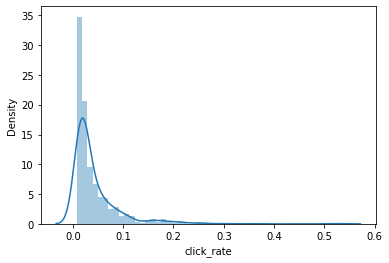

In [ ]:
sns.distplot(df_testcopy['click_rate'])

In [ ]:
df_testcopy[['campaign_id','click_rate']].to_csv('solution_nihal_habeeb.csv', index = False)

### XGBoost

In [ ]:
xgb = XGBRegressor(learning_rate=0.02, n_estimators=600)
# # xgb.fit(X_train, y_train)

In [ ]:
# hyperparameter tuning
# parameter grid
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_cv = GridSearchCV(xgb, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 3)
xgb_cv.fit(X_train, y_train)

[17:20:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=3, estimator=XGBRegressor(learning_rate=0.02, n_estimators=600),
             param_grid={'max_depth': [5, 7, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [ ]:
y_train_pred = xgb_cv.predict(X_train)
y_pred = xgb_cv.predict(X_test)

In [ ]:
r2_score(y_train, y_train_pred)

0.32276566845351917

In [ ]:
r2_score(y_test, y_pred)

-0.16955022970096323

In [ ]:
# xgb.score(X_train, y_train)

In [ ]:
# xgb.score(X_test, y_test)